# Low tumor fraction samples

In [1]:
# Imports

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
warnings.filterwarnings('ignore')

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import set_display_params
from utils.util_lift_over import liftover
from lowtfsamples.low_tumor_fraction_samples_identify import plot_patient_timeline, get_mutations_stats
from lowtfsamples.low_tumor_fraction_samples_check import check_pileup

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)

paper


In [3]:
# order of samples = 1) high tb sample 1, 2) high tb sample 2, 3) low tb sample
patientsample_dict = {
    '1014': ['NCC_CRC-1014_180816-CW-T', 'NCC_CRC-1014_110116-CW-T', 'NCC_CRC-1014_090516-CW-T'],
    '986': ['NCC_CRC-986_100215-CW-T', 'NCC_CRC-986_261016-CW-T', 'NCC_CRC-986_300316-CW-T'],
    '123': ['NCC_CRC-123_310715-CW-T', 'NCC_CRC-123_070116-CW-T', 'NCC_CRC-123_121115-CW-T']
}


In [4]:
targetbedhg19 = pd.read_csv(os.path.join(*config.extdatafolder, 'Cancer226-targets_hg19.bed'), sep='\t')
targetbedhg38 = pd.read_csv(os.path.join(*config.extdatafolder, 'Cancer226-targets_hg38.bed'), sep='\t')

print(targetbedhg19.shape)
targetbedhg19list = []
for i, r in targetbedhg19.iterrows():
    ra = r[2] +1 - r[1]
    rb = targetbedhg38.iloc[i, 2]+1-targetbedhg38.iloc[i, 1]
    if r[2] <= r[1]:
        raise ValueError('issue with {}'.format(r))
    for p in range(r[1], r[2]+1):
        targetbedhg19list.append('{}_{}'.format(r[0][3:], p))
    if ra != rb:
        print(ra, rb, i)
        for a in range(rb - ra):
            targetbedhg19list.append('{}_{}'.format(r[0][3:], p))
print(len(targetbedhg19list))
print(targetbedhg19list[0])

targetbedhg38list = []
for _, r in targetbedhg38.iterrows():
    for p in range(r[1], r[2]+1):
        targetbedhg38list.append('{}_{}'.format(r[0], p))
print(len(targetbedhg38list))
print(targetbedhg38list[0])

(3879, 6)
785 788 1215
750587
12_46123619
750587
chr12_45729836


# Paired VAF Plots high and low tb samples

In [5]:
seqtype = 'deepWGS'
patient = '1014'

In [6]:
mutationfile = pd.read_excel(os.path.join(*config.mutationfolder, [f for f in os.listdir(os.path.join(*config.mutationfolder)) if f.startswith('CCG_226_'+patient)][0]))
print(mutationfile.shape)
mutationfile['chrom_pos'] = mutationfile['#CHROM'].astype('str').str.cat(mutationfile['POS'].astype('str'), sep="_")
mutationfile.set_index('chrom_pos', inplace=True)
print(mutationfile.shape)
mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
print(mutationfile.shape)

# if hg19 need to liftover
#if seqtype == 'deepWGS':
#    mutationfile.reset_index(inplace=True)
#    mutationfile['chrom_pos'].apply(lambda x: liftover(x, os.path.join(*config.extdatafolder, 'hg38ToHg19.over.chain')))
#    mutationfile['chrom_pos'] = mutationfile['chrom_pos'].apply(lambda x: x.split('_')[0][3:] + '_' + x.split('_')[1]) ###
#    mutationfile.set_index('chrom_pos', inplace=True)
#    mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
#print(mutationfile.shape)

if seqtype == 'deepWGS':
    mutationfile.reset_index(inplace=True)
    for i in range(mutationfile.shape[0]):
        if mutationfile['chrom_pos'].iloc[i] in targetbedhg38list:
            val = targetbedhg19list[targetbedhg38list.index(mutationfile['chrom_pos'].iloc[i])]
            mutationfile.iat[i, 0] = val
        else:
            mutationfile.iloc[i]['chrom_pos'] = np.nan
            print(i, mutationfile['chrom_pos'].iloc[i])
    # mutationfile['chrom_pos'].apply(lambda x: targetbedhg19list[targetbedhg38list.index(x)])
    mutationfile['chrom_pos'] = mutationfile['chrom_pos'].apply(lambda x: x.split('_')[0][:3] + '_' + x.split('_')[1]) ###
    mutationfile.set_index('chrom_pos', inplace=True)
    print(mutationfile.shape)
    mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
mutationfile = mutationfile.loc[~mutationfile.index.duplicated()]
print(mutationfile.shape)

(99, 17)
(99, 17)
(81, 17)
(81, 17)
(81, 17)


NCC_CRC-1014_110116-CW-T NCC_CRC-1014_090516-CW-T
(757479, 10)
750308
750587
(757713, 10)
750542
750587
No annotation    757673
Artifact             49
Germline             15
LowEvidence          12
Trusted               5
Name: annotation, dtype: int64


Text(0.5, 1.0, 'Paired VAF plot in pileup in deepWGS seq\n for 1014_090516 VS 1014_110116')

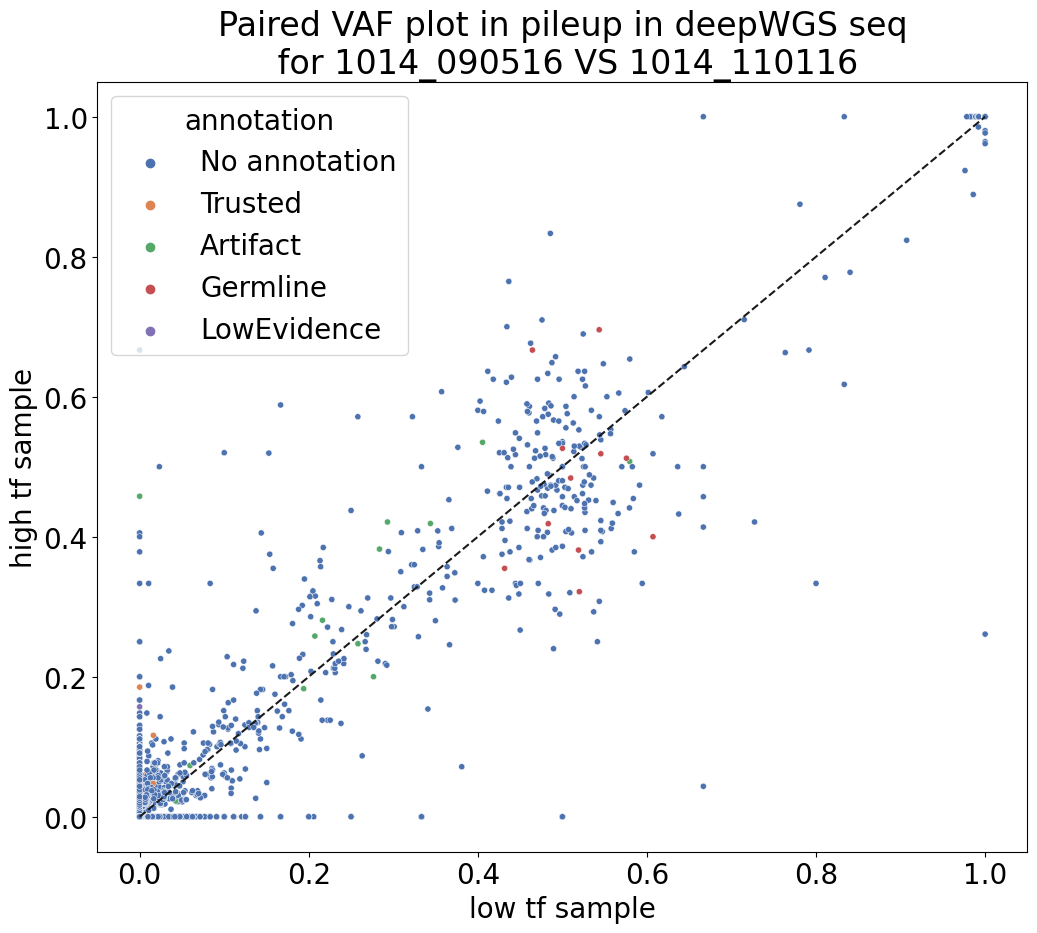

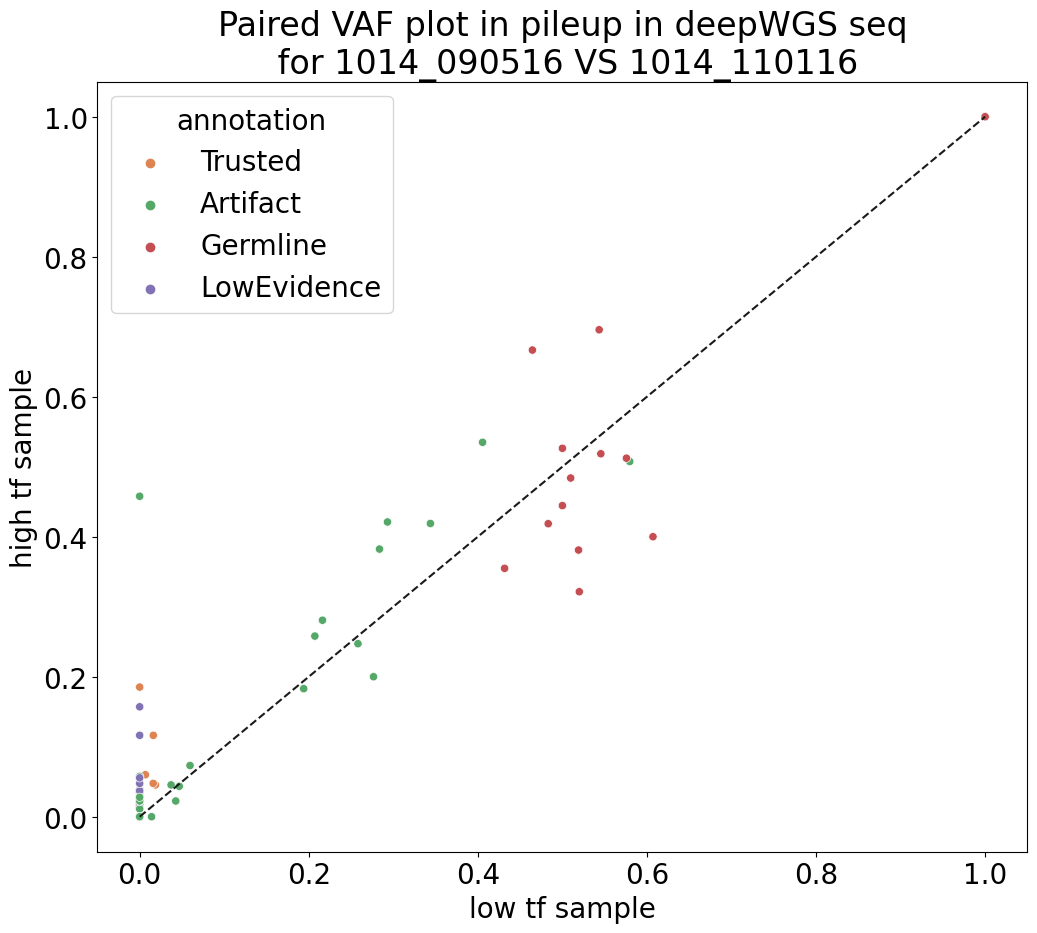

In [9]:
print(patientsample_dict[patient][1], patientsample_dict[patient][2])
lowtfsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', patientsample_dict[patient][2] + '_' + seqtype + '_vaf.txt'), index_col=0)
lowtfsample_vaf_df['chrom_pos'] = lowtfsample_vaf_df['chrom'].astype('str').str.cat(lowtfsample_vaf_df['pos'].astype('str'), sep="_")
lowtfsample_vaf_df.set_index('chrom_pos', inplace=True)
lowtfsample_vaf_df = lowtfsample_vaf_df.loc[~lowtfsample_vaf_df.index.duplicated()]
print(lowtfsample_vaf_df.shape)
print(len(list(set(targetbedhg19list) & set(lowtfsample_vaf_df.index))))
print(len(targetbedhg19list))
hightfsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', patientsample_dict[patient][1] + '_' + seqtype + '_vaf.txt'), index_col=0)
hightfsample_vaf_df['chrom_pos'] = hightfsample_vaf_df['chrom'].astype('str').str.cat(hightfsample_vaf_df['pos'].astype('str'), sep="_")
hightfsample_vaf_df.set_index('chrom_pos', inplace=True)
hightfsample_vaf_df = hightfsample_vaf_df.loc[~hightfsample_vaf_df.index.duplicated()]
print(hightfsample_vaf_df.shape)
print(len(list(set(targetbedhg19list) & set(hightfsample_vaf_df.index))))
print(len(targetbedhg19list))
paired_vaf_df = pd.concat([lowtfsample_vaf_df['vaf'], hightfsample_vaf_df['vaf']], axis=1)
paired_vaf_df.columns = ['low tf sample', 'high tf sample']
paired_vaf_df['low_high_vaf'] = paired_vaf_df['low tf sample'].round(2).astype('str').str.cat(paired_vaf_df['high tf sample'].round(2).astype('str'), sep="_")
occurence_dict = paired_vaf_df['low_high_vaf'].value_counts()
paired_vaf_df['size'] = paired_vaf_df['low_high_vaf'].apply(lambda x: occurence_dict[x]).astype(int)
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 5), (5, 10), (10, 20), (20, 50), (50, paired_vaf_df['size'].max()+1)])
paired_vaf_df['size'] = pd.qcut(paired_vaf_df['size'], 10, duplicates='drop', labels=False) # labels=['=1', '≤5', '≤10', '≤20', '≤50', '>50'])
paired_vaf_df.loc[list(set(mutationfile.index) & set(paired_vaf_df.index)), 'annotation'] = mutationfile['TIERS']
paired_vaf_df['annotation'] = 'No annotation'
paired_vaf_df.loc[mutationfile.index, 'annotation'] = mutationfile['TIERS']
# paired_vaf_df.loc[list(set(mutationfile.index) & set(paired_vaf_df.index)), 'annotation'] = mutationfile['TIERS']
# paired_vaf_df.reindex(mutationfile.index)['annotation'] = mutationfile['TIERS']
print(paired_vaf_df['annotation'].value_counts())

plt.figure(figsize=(12,10))
sns.scatterplot(x='low tf sample', y='high tf sample',  s=20, hue='annotation', data=paired_vaf_df)
plt.plot([0,1], [0,1], ls='--', c='k')
plt.title('Paired VAF plot in pileup in {} seq\n for {} VS {}'.format(seqtype,patientsample_dict[patient][2].split('-')[1], patientsample_dict[patient][1].split('-')[1]))

plt.figure(figsize=(12,10))
sns.scatterplot(x='low tf sample', y='high tf sample', hue='annotation', data=paired_vaf_df[(paired_vaf_df['annotation'] != 'No annotation')], palette=sns.color_palette()[1:(paired_vaf_df['annotation'].nunique())])
plt.plot([0,1], [0,1], ls='--', c='k')
plt.title('Paired VAF plot in pileup in {} seq\n for {} VS {}'.format(seqtype,patientsample_dict[patient][2].split('-')[1], patientsample_dict[patient][1].split('-')[1]))

# Paired VAF Plots targeted and deep samples

In [55]:
patient = '1014'
sample = 'NCC_CRC-1014_090516-CW-T'

In [57]:
print(sample)
deepWGSsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', sample + '_deepWGS_vaf.txt'), index_col=0)
deepWGSsample_vaf_df['chrom_pos'] = deepWGSsample_vaf_df['chrom'].astype('str').str.cat(deepWGSsample_vaf_df['pos'].astype('str'), sep="_")
deepWGSsample_vaf_df.set_index('chrom_pos', inplace=True)
deepWGSsample_vaf_df.drop_duplicates(inplace=True)
deepWGSsample_vaf_df = deepWGSsample_vaf_df.loc[~deepWGSsample_vaf_df.index.duplicated()]
targetedsample_vaf_df = pd.read_csv(os.path.join(*config.lowtfsamplesfolder, 'targeted', sample + '_targeted_vaf.txt'), index_col=0)
targetedsample_vaf_df['chrom_pos'] = targetedsample_vaf_df['chrom'].astype('str').str.cat(targetedsample_vaf_df['pos'].astype('str'), sep="_")
targetedsample_vaf_df.set_index('chrom_pos', inplace=True)
targetedsample_vaf_df.drop_duplicates(inplace=True)
targetedsample_vaf_df = targetedsample_vaf_df.loc[~targetedsample_vaf_df.index.duplicated()]

# liftover targeted hg38 to hg19
targetedsample_vaf_df.reset_index(inplace=True)
targetedsample_vaf_df['chrom_pos'].apply(lambda x: liftover(x, os.path.join(*config.extdatafolder, 'hg38ToHg19.over.chain')))
targetedsample_vaf_df['chrom_pos'] = targetedsample_vaf_df['chrom_pos_pos'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
targetedsample_vaf_df.set_index('chrom_pos', inplace=True)
targetedsample_vaf_df = targetedsample_vaf_df.loc[~targetedsample_vaf_df.index.duplicated()]


paired_vaf_df = pd.concat([deepWGSsample_vaf_df['vaf'], targetedsample_vaf_df['vaf']], axis=1)
paired_vaf_df.columns = ['low tf sample', 'high tf sample']
paired_vaf_df['low_high_vaf'] = paired_vaf_df['low tf sample'].round(2).astype('str').str.cat(paired_vaf_df['high tf sample'].round(2).astype('str'), sep="_")
occurence_dict = paired_vaf_df['low_high_vaf'].value_counts()
paired_vaf_df['size'] = paired_vaf_df['low_high_vaf'].apply(lambda x: occurence_dict[x]).astype(int)
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 5), (5, 10), (10, 20), (20, 50), (50, paired_vaf_df['size'].max()+1)])
paired_vaf_df['size'] = pd.qcut(paired_vaf_df['size'], 10, duplicates='drop', labels=False) # labels=['=1', '≤5', '≤10', '≤20', '≤50', '>50'])

NCC_CRC-1014_090516-CW-T


KeyboardInterrupt: 